# Juice Tracking

Copyright (c) 2010-2024, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context

This is a **temporary** example, using the `TrackingTxtFileReader` and `DopplerMeasuredFrequencyObservationModel` to reproduce JUICE doppler measurements. 

The following shows the transmitted frequencies as reported by ESA for the relevant times:
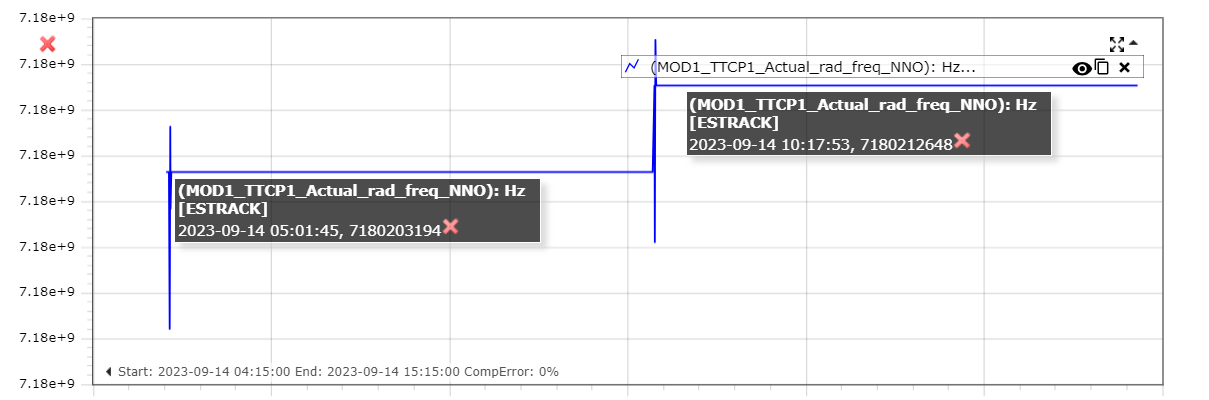


## Prerequisites

To run this example, make sure to download [the data file](https://space.phys.utas.edu.au/docs/juice/jc230914/Hb/dop2/Fdets.jui2023.09.14.Hb.r2i.txt) from the database and store it in a subfolder called [./data](./data) (or adjust the filename below to the absolute path of your choice). If you are using a terminal, you could get the JUICE data by running the follownig commands from the current directory:

```bash
mkdir -p data
(cd data && curl -O https://space.phys.utas.edu.au/docs/juice/jc230914/Hb/dop2/Fdets.jui2023.09.14.Hb.r2i.txt)
```

Then set the filename of the tracking data accordingly



In [1]:
# Set the filename of the data file
TRACKING_FNAME = "./data/Fdets.jui2023.09.14.Hb.r2i.txt"
IONOSPHERIC_CORR_FNAME = "./data/mromagr2017_091_2017_121.ion.txt" # FIXME: should be a JUICE file instead of MRO (not used in this script)

# Check if you have the file in the correct place
try:
    with open(TRACKING_FNAME, "r") as f_transmit:
        pass
except FileNotFoundError:
    print(
        f"FILE {TRACKING_FNAME} NOT FOUND. Make sure you have downloaded the data file and stored in the correct place."
    )
    exit(1)
    
    

## Import statements

Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported. Most notably, some elements of the `observation`, `estimation` and `estimation_setup` modules will be used and demonstrated within this example.

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Tudatpy imports
from tudatpy import data
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy.numerical_simulation import environment_setup, environment
from tudatpy.numerical_simulation import estimation, estimation_setup, propagation_setup, Estimator
from tudatpy.numerical_simulation.estimation_setup import observation 
from tudatpy.astro import time_conversion, element_conversion

In [3]:
spice.clear_kernels()
spice.load_standard_kernels()

file_columns = [
    "scan_id",
    "utc_datetime_string",
    "signal_to_noise_ratio", 
    "normalised_spectral_max", 
    "doppler_measured_frequency_hz", 
    "doppler_noise_hz",
]

# Read the data file
raw_datafile = data.read_tracking_txt_file(
    file_name=TRACKING_FNAME, column_types=file_columns, comment_symbol="#", value_separators=",\t "
)

In [4]:
raw_datafile.add_metadata_val(data.TrackingDataType.doppler_base_frequency, 8435e6) 
raw_datafile.add_metadata_str(data.TrackingDataType.vlbi_station_name, "HOBART12")

# Set the frequency bans (necessary for frquency turnaround ratio)
ancillary_settings = observation.doppler_measured_frequency_ancillary_settings([observation.FrequencyBands.x_band] * 2)

# FIXME: REMOVE (just for reference)
# enum ObservationAncilliarySimulationVariable
# {
#     doppler_integration_time,
#     link_ends_delays,
#     doppler_reference_frequency,
#     frequency_bands,
#     reception_reference_frequency_band
# };

In [5]:
# Create the observation collection
observations = observation.create_tracking_txtfile_observation_collection(
    raw_datafile, "JUICE", ancillary_settings=ancillary_settings
)


In [6]:
observation_times = np.array(observations.concatenated_times)
measured_observation_vals = observations.concatenated_observations

# observation_vals += 8420.0e6

times_rel_hr = (observation_times - observation_times[0]) / 3600.0
obs_start_epoch = observation_times[0]
obs_end_epoch = observation_times[-1]
obs_start_time = time_conversion.date_time_from_epoch(obs_start_epoch)

# Set the transmission frequency information (from figure above)
transmit_freq_step_time = time_conversion.DateTime(2023, 9,14, 10,17,53)
transmit_freq_step_epoch = transmit_freq_step_time.epoch()
time_transmit_freq_step_rel_hr = (transmit_freq_step_epoch - obs_start_epoch) / 3600

f_transmit_1 = 7180203194.0
f_transmit_2 = 7180212648.0

f_transmit = (times_rel_hr < time_transmit_freq_step_rel_hr) * f_transmit_1 + (times_rel_hr >= time_transmit_freq_step_rel_hr) * f_transmit_2

In [7]:
spice.clear_kernels()
spice.load_standard_kernels()
spice.load_kernel("./data/juice_orbc_000056_230414_310721_v01.bsp")


In [8]:
# Checking that the spice kernels are loaded
spice.get_body_cartesian_state_at_epoch(
            target_body_name="JUICE",
            observer_body_name='Sun',
            reference_frame_name='J2000',
            aberration_corrections='none',
            ephemeris_time=1e9)

array([ 8.56281335e+09, -7.21020511e+11, -3.09227717e+11, -4.02003661e+02,
       -2.79896173e+03, -1.95725872e+03])

In [9]:
# Create default body settings
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus", "Jupiter", "Saturn"]
global_frame_origin = "SSB"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

# Add rotation model
body_settings.get("Earth").rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
    environment_setup.rotation_model.iau_2006, global_frame_orientation
)

# Add JUICE with spice ephemeris
bodies_to_create.append("JUICE")
body_settings.add_empty_settings("JUICE")
body_settings.get("JUICE").ephemeris_settings = environment_setup.ephemeris.direct_spice("Sun", "J2000")

# Create the system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

# Vehicle systems
vehicleSystems = environment.VehicleSystems()

# FIXME: This should be automatic --> Set the function instead of map
vehicleSystems.set_transponder_turnaround_ratio(
    {
        (
            observation.FrequencyBands.x_band,
            observation.FrequencyBands.x_band,
        ): observation.dsn_default_turnaround_ratios(
            observation.FrequencyBands.x_band, observation.FrequencyBands.x_band
        )
    }
)

bodies.get("JUICE").system_models = vehicleSystems

# Create the ground station with correct transmitting frequency
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "HOBART12",
    [-3949990.106, 2522421.118, -4311708.734],
    element_conversion.cartesian_position_type,
)

transmittingFrequencyCalculator = environment.PiecewiseLinearFrequencyInterpolator(
    [obs_start_epoch - 36000, transmit_freq_step_epoch],
    [transmit_freq_step_epoch, obs_end_epoch + 36000],
    [0.0, 0.0],
    [f_transmit_1, f_transmit_2],
)

bodies.get("Earth").get_ground_station("HOBART12").set_transmitting_frequency_calculator(
    transmittingFrequencyCalculator
)

In [10]:

bodies.get("JUICE").mass = 2400

# # Define bodies that are propagated
bodies_to_propagate = ["JUICE"]

# Define central bodies of propagation
central_bodies = ["Sun"]

# Add radiation pressure settings
reference_area_radiation = 85.0 # FIXME: should probably be panelled instead of cannonball (rotation model)
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = {}
occulting_bodies_dict[ "Sun" ] = [ "Earth" ]
vehicle_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area_radiation, radiation_pressure_coefficient, occulting_bodies_dict )
environment_setup.add_radiation_pressure_target_model( bodies, "JUICE", vehicle_target_settings )



In [11]:
acceleration_settings = {
    "JUICE": {
        "Sun": [
            propagation_setup.acceleration.point_mass_gravity(),
            propagation_setup.acceleration.radiation_pressure(),
        ],
        "Mars": [propagation_setup.acceleration.point_mass_gravity()],
        "Moon": [propagation_setup.acceleration.point_mass_gravity()],
        "Earth": [propagation_setup.acceleration.point_mass_gravity()],
        "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
        "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    }
}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

In [12]:
# Extract the relevant information from the real observations to mimic
linkdef_ids = observations.concatenated_link_definition_ids
distinct_linkdefs = observations.get_link_definitions_for_observables(observation.doppler_measured_frequency_type)

# Add light-time corrections
# Define settings for light-time calculations
light_time_correction_settings_list = [
    observation.first_order_relativistic_light_time_correction(["Sun", "Earth"]),
    # observation.dsn_tabulated_ionospheric_light_time_correction([IONOSPHERIC_CORR_FNAME], {74: "JUICE"}),
]

# Create the observation model settings to match those of the real observations
observation_model_settings = [
    estimation_setup.observation.doppler_measured_frequency(
        distinct_linkdefs[linkdef_id],
        light_time_correction_settings=light_time_correction_settings_list,
    )
    for linkdef_id in linkdef_ids
]

In [13]:
# Create the observation simulators
observation_simulators = estimation_setup.create_observation_simulators(observation_model_settings, bodies)

# Get the simulator settings directly from the real observations
observation_simulation_settings = estimation_setup.observation.observation_settings_from_collection(observations)

# Simulate the observations
simulated_observations = estimation.simulate_observations(observation_simulation_settings, observation_simulators, bodies)


In [14]:
simulated_observation_vals = simulated_observations.concatenated_observations
simulated_times = simulated_observations.concatenated_times

# Assume only one link definition
link_ends = simulated_observations.link_ends_per_observable_type[observation.doppler_measured_frequency_type][0]

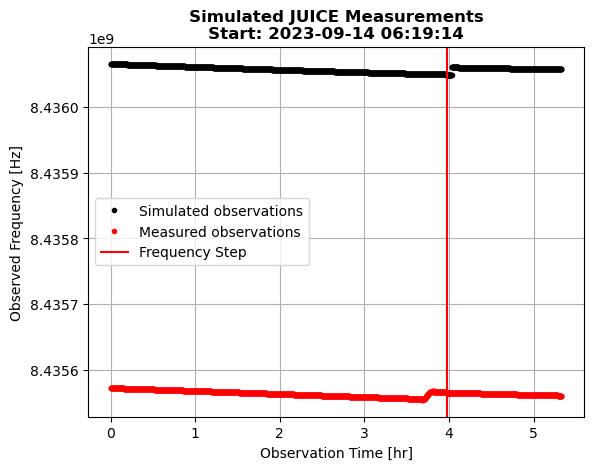

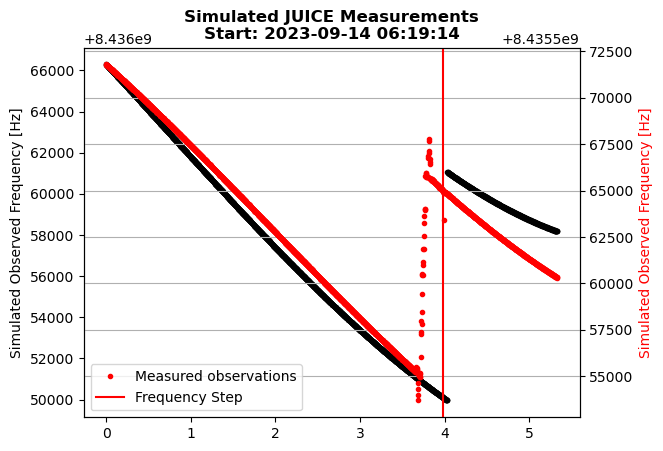

In [15]:
plt.figure()
plt.title(f"Simulated JUICE Measurements\nStart: {obs_start_time.iso_string():.19s}", weight="bold")
plt.plot(times_rel_hr, simulated_observation_vals, "k.", label="Simulated observations")
plt.plot(times_rel_hr, measured_observation_vals , "r.", label="Measured observations")
plt.axvline(time_transmit_freq_step_rel_hr, color="red", label="Frequency Step")
plt.xlabel("Observation Time [hr]")
plt.ylabel("Observed Frequency [Hz]")
plt.legend()
plt.grid("on")

plt.figure()
plt.title(f"Simulated JUICE Measurements\nStart: {obs_start_time.iso_string():.19s}", weight="bold")
plt.plot(times_rel_hr, simulated_observation_vals, "k.", label="Simulated observations")
plt.ylabel("Simulated Observed Frequency [Hz]")
plt.gca().twinx()
plt.plot(times_rel_hr, measured_observation_vals , "r.", label="Measured observations")
plt.axvline(time_transmit_freq_step_rel_hr, color="red", label="Frequency Step")
plt.xlabel("Observation Time [hr]")
plt.ylabel("Simulated Observed Frequency [Hz]",  color="red")
plt.legend()
plt.grid("on")

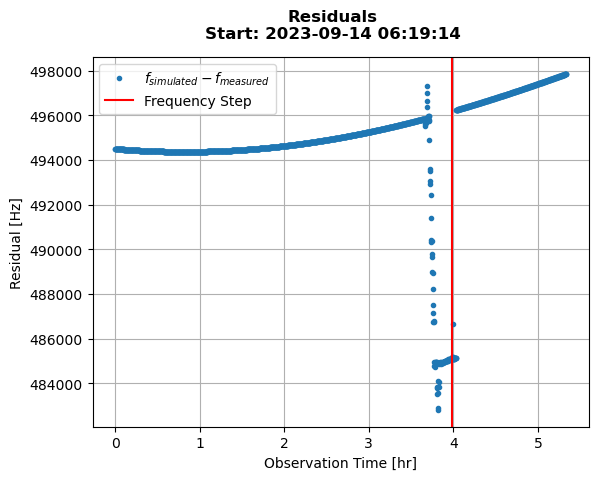

In [16]:
# Residuals

residuals = simulated_observation_vals - measured_observation_vals

plt.figure()
plt.suptitle(f"Residuals\nStart: {obs_start_time.iso_string():.19s}", weight="bold")
plt.plot(times_rel_hr, residuals, ".", label=r"$f_{simulated} - f_{measured}$")
plt.axvline(time_transmit_freq_step_rel_hr, color="red", label="Frequency Step")
plt.xlabel("Observation Time [hr]")
plt.ylabel("Residual [Hz]")
plt.grid("on")
plt.legend()


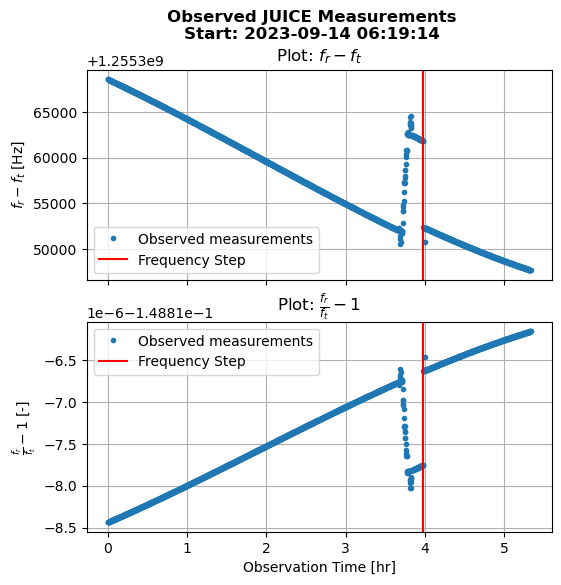

In [17]:
# These are just some random plots that I made tryinig to understand what was going on

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
# fig.subplots_adjust(top=0.8)

fig.suptitle(f"Observed JUICE Measurements\nStart: "f"{obs_start_time.iso_string():.19s}", weight="bold")
axs[0].plot(times_rel_hr, (measured_observation_vals-f_transmit), ".", label="Observed measurements")
ylabel = r"$f_r - f_t$"

axs[0].set_title(f"Plot: {ylabel}")
axs[0].set_ylabel(f"{ylabel} [Hz]")

ylabel = r"$\frac{f_r}{f_t} - 1$"
axs[1].set_title(f"Plot: {ylabel}")
axs[1].plot(times_rel_hr, (f_transmit / measured_observation_vals - 1) , ".", label="Observed measurements")
axs[1].set_ylabel(f"{ylabel} [-]")

axs[1].set_xlabel("Observation Time [hr]")

for ax in axs:
    ax.axvline(time_transmit_freq_step_rel_hr, color="red", label="Frequency Step")
    ax.grid("on")
    ax.legend()
plt.show()

## Estimation process

In [18]:
simulation_start_epoch = simulated_times[0]
simulation_end_epoch = simulated_times[-1]
time_step = simulated_times[1] - simulated_times[0]

# initial state
initial_state = spice.get_body_cartesian_state_at_epoch(
            target_body_name="JUICE",
            observer_body_name='Sun',
            reference_frame_name='J2000',
            aberration_corrections='none',
            ephemeris_time=simulation_start_epoch)

# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition
)
link_definition = observation.LinkDefinition(link_ends)
observation_settings_list = [observation.doppler_measured_frequency(link_definition)]

In [19]:
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)
# parameter_settings = [estimation_setup.parameter.gravitational_parameter("Sun")]

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies)

In [20]:
# Tabulate JUICE ephemeris
bodies.get_body("JUICE").ephemeris = environment_setup.create_tabulated_ephemeris_from_spice( 
    "JUICE",
    simulation_start_epoch, 
    simulation_end_epoch, 
    time_step,
    global_frame_origin,
    global_frame_orientation, 
)

# Create the estimator
estimator = Estimator(
    bodies,
    parameters_to_estimate,
    observation_settings_list,
    propagator_settings)

RuntimeError: Error when getting undifferenced observable type for NWayDopplerMeasuredFrequency, no such type exists

In [ ]:
convergence_checker = estimation.estimation_convergence_checker(maximum_iterations=4)
estimation_input = estimation.EstimationInput(
    simulated_observations,
    convergence_checker=convergence_checker)

# Set methodological options
estimation_input.define_estimation_settings(
    reintegrate_variational_equations=False)

In [ ]:
# Perform the estimation
estimation_output = estimator.perform_estimation(estimation_input)